# 目标：

    1、将mnist数据转换成tf_records形式的文件。

In [22]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [6]:
MNIST = input_data.read_data_sets('./mnist/')

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [20]:
'''
获取训练用数据
'''
all_img = np.reshape(MNIST.train.images,(-1,28,28))
all_label = MNIST.train.labels
all_img.shape,all_label.shape

((55000, 28, 28), (55000,))

In [58]:
'''
获取测试用数据
'''
all_val_img = np.reshape(MNIST.validation.images,(-1,28,28))
all_val_label = MNIST.validation.labels
all_val_img.shape,all_val_label.shape

((5000, 28, 28), (5000,))

In [86]:
all_label[:10],all_val_label[:10]

(array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8], dtype=uint8),
 array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8))

In [87]:
# 将其保存成tfrecords类型的文件
def to_tfrecords(local_images,local_labels,record_name):
    writer = tf.python_io.TFRecordWriter(record_name)
    for temp_img,temp_label in zip(local_images,local_labels):

        temp_img = Image.fromarray(temp_img)
        img_raw = temp_img.tobytes()

        example = tf.train.Example(features=tf.train.Features(feature={
            'label':tf.train.Feature(int64_list = tf.train.Int64List(value=[temp_label])),
            'img_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
        }))
        writer.write(example.SerializeToString())

    writer.close()

In [88]:
# 得到训练数据的tf_records
# to_tfrecords(all_img,all_label,'mnist.tfrecords')

# 得到测试数据的tf_records
to_tfrecords(all_val_img,all_val_label,'mnist_val.tfrecords')

In [89]:
'''
基本的读取TF_RECORDS数据的方式
'''
def read_and_parse(filename):
    filename_queue = tf.train.string_input_producer([filename])
    
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename_queue)
    
    # 相比于下面
    # 另一种我觉得比较清楚的写法
    features_dict = {
        'label':tf.FixedLenFeature([],tf.int64),
        'img_raw':tf.FixedLenFeature([],tf.string)
    }
    features_res = tf.parse_single_example(serialized_example,features=features_dict)
    
    # 这里算是把书籍写到了这个feature里面
    # 这个feature可以认为是一个dict
#     features_res = tf.parse_single_example(serialized_example,features={
#         'label':tf.FixedLenFeature([],tf.int64),
#         'img_raw':tf.FixedLenFeature([],tf.string),
#     })
    
    # 这里应该怎么解码，看原来的数据是怎样的。
    # 原来数据是float32，那么这里也要相应的解码
    img = tf.decode_raw(features_res['img_raw'],tf.int32)
    img = tf.reshape(img,[28,28])
    label = tf.cast(features_res['label'],tf.int32)
    
    return img,label
    

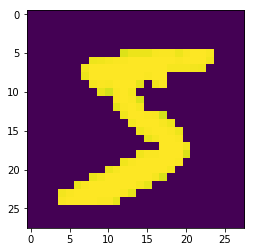

(28, 28) 5


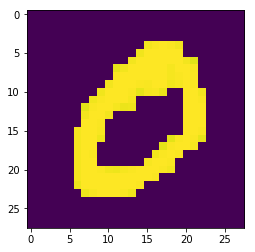

(28, 28) 0


In [90]:
'''
 测试
'''
tf.reset_default_graph()
img,label = read_and_parse('mnist_val.tfrecords')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 暂时理解为控制多个线程同时结束的方法
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(2):
        example,l = sess.run([img,label])
        plt.imshow(example)
        plt.show()
        print(example.shape,l)
    coord.request_stop()
    coord.join(threads)

# tf.dataset使用

从核心功能上来看，dataset就像是一个包装器：

    1、它不定义解读数据的方法，需要我们自己定义。
    2、他不提供数据后续操作的方法，需要我们自己定义。
    3、它仅提供把数据操作方法，应用到对应数据上的这个操作，并且负责拿到返回值。
 
从操作的数据对象上看，可以有这么几种：

    1、tf.data.TFRecordDataSet;专门用来操作TFRecord对象的。
    2、tf.data.TextLineDataset;专门用来操作csv或者txt对象的。
    。。。。

在得到了不同的DataSet后，他们都是通过获取迭代器iterator来获取数据的，这里又有不同的迭代器：

    1、make_one_shot_iterator()；和数据绑死，不能重新选择数据源。
    2、make_initializable_iterator();和数据解绑，可以重新选择数据源：
        2.1 需要注意，不同的数据源之间，格式要统一，因为用的解码方法还是同一个。

In [91]:
'''
试着使用tf.dataset的方法来进行操作：
    1、解析TFRECORD文件
    2、做一些简单的后处理
'''
def parser(record):
    '''
        这个函数是定义，对于tfrecords中的一个records而言，
        该怎么操作
    '''
    features = {
        'label':tf.FixedLenFeature([],tf.int64),
        'img_raw':tf.FixedLenFeature([],tf.string)
    }
    
    parsed = tf.parse_single_example(record,features)
    
    image = tf.decode_raw(parsed['img_raw'],tf.int32)
    image = tf.reshape(image,[28,28])
    label = tf.cast(parsed['label'],tf.int32)
    return image,label

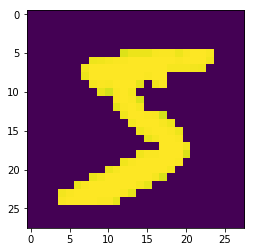

In [92]:
'''
简单的 make_one_shot_iterator的使用：
    1、写死tfrecord位置，作为初始化参数，拿到DataSet对象。
    2、利用map方法，传入对每一行数据操作的方法。
    3、利用dataset对象拿到iterator对象。
    4、利用iterator的get_next方法，获取数据
'''
tf.reset_default_graph()

filename=['./mnist_val.tfrecords']
dataset = tf.data.TFRecordDataset(filename)
dataset  =dataset.map(parser)

iterator = dataset.make_one_shot_iterator()
image,label = iterator.get_next()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    se_image  =sess.run(image)
    plt.imshow(se_image)
    plt.show()

(32, 28, 28)


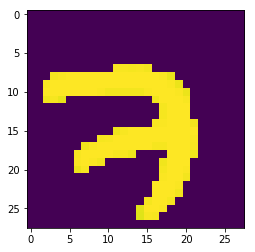

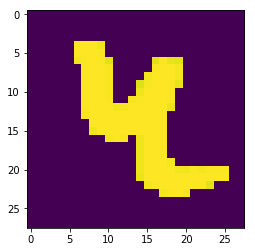

(32, 28, 28)


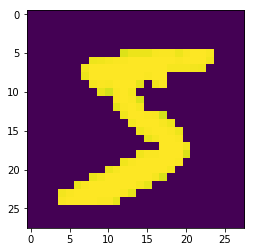

In [95]:
'''
make_initializable_iteration()方法：
    1、定义placehodler，作为后续tfrecords位置的传入点。
    2、将placeholder作为初始化参数，得到dataset对象。
    3、定义一些batch，epoch，shuffle的信息。
    4、设定迭代器类型：make_initializable_iterator
    5、用get_next获取数据:image,label
    6、sess中，初始化变量。
    7、显示初始化：sess.run(iterator_init.initializer,feed_dict={file_names:training_filenames})
    8、获取真实数据：sess.run(images)
'''

tf.reset_default_graph()

file_names = tf.placeholder(dtype=tf.string,shape=[None])

dataset = tf.data.TFRecordDataset(file_names) # 注意这里传入的是placeholder
dataset = dataset.map(parser) # 别忘了map这个处理函数
dataset = dataset.batch(32) # 在这里可以设定batch_size

iterator_init = dataset.make_initializable_iterator()
images,label = iterator_init.get_next()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 获得训练数据
    training_filenames = ['./mnist.tfrecords']
    sess.run(iterator_init.initializer,feed_dict={file_names:training_filenames})
    train_image = sess.run(images)
    train_image2 = sess.run(images)
    print(train_image.shape)
    plt.imshow(train_image[0,:,:])
    plt.show()
    
    plt.imshow(train_image2[0,:,:])
    plt.show()
    
    # 获得测试数据
    validation_filenames=['./mnist_val.tfrecords']
    sess.run(iterator_init.initializer,feed_dict={file_names:validation_filenames})
    valid_image = sess.run(images)
    print(valid_image.shape)
    plt.imshow(valid_image[0,:,:])
    plt.show()